<div style="line-height:0.45">
<h1 style="color:#0DB1A7  "> Softmax example 1 </h1>
</div>
<div style="line-height:0.5">
<h4> Softmax custom class 
</h4>
<div style="margin-top: -3px;">
<span style="display: inline-block;">
    <h3 style="color: lightblue; display: inline;">Keywords:</h3> getattr + itemgetter + globals
</span>
</div>

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
from operator import itemgetter

<h3 style="color: #0DB1A7;"> Note: </h3>
<div style="margin-top: -8px;">
itemgetter return a callable object that fetches the given item(s) from its operand.<br>


- After f = itemgetter(2), the call f(r) returns r[2] <br>
- After g = itemgetter(2, 5, 3), the call g(r) returns (r[2], r[5], r[3]) <br>

In [70]:
a = np.array([6,4,2,3,1])
np.hstack((a,1))

array([6, 4, 2, 3, 1, 1])

In [71]:
class Softmax:
    """ Custom Softmax Classifier.

    Args:
        - Size of each mini-batch used during training [int (default is 50)]
        - Number of training epochs [int (default is 1000)]
        - Learning rate for gradient descent [float (default is 0.01 or 1e-2).]
        - Regularization strength [float(default is 1e-5)]
        - Weight update method, which can be 'adam' or other update methods [str (default is 'adam')]

    Methods:
        - train(self, X, y)
        - predict(self, X)
        - loss(self, X, y, W, b, reg_strength)
        - sgd(self, X, y, config)
        - sgd_with_momentum(self, X, y, config)
        - rms_prop(self, X, y, config)
        - adam(self, X, y, config)
        - sample_and_calculate_gradient(self, X, y, batch_size, w, b, reg_strength)
    """    
    def __init__(self, batch_size=50, epochs=1000, learning_rate=1e-2, reg_strength=1e-5, weight_update='adam'):
        """ Constructor to initialize the Softmax classifier with specified hyperparameters. """
        self.W = None
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.reg_strength = reg_strength
        self.weight_update = weight_update
        self.loss_history = []

    def train(self, X, y):
        """ Train the Softmax classifier.

        Parameters:
            - Input data of shape (num_samples, num_features) [ndarray]
            - Labels [ndarray, shape (num_samples,)]
        """        
        n_features = X.shape[1]
        n_classes = 4
        # Initialize the weight matrix with random values
        self.W = np.random.randn(n_features, n_classes) / np.sqrt(n_features/2)
        
        # Create the configuration dictionary for optimization methods
        config = {'reg_strength': self.reg_strength, 'batch_size': self.batch_size,
                'learning_rate': self.learning_rate, 'eps': 1e-8, 'decay_rate': 0.99,
                'momentum': 0.9, 'cache': None, 'beta_1': 0.9, 'beta_2':0.999,
                'velocity': np.zeros(self.W.shape)}
        # Get a reference to the Softmax class
        c = globals()['Softmax']
        
        for epoch in range(self.epochs):
            # Call the selected weight update method dynamically
            loss, config = getattr(c, self.weight_update)(self, X, y, config)
            self.loss_history.append(loss)
            print ("Epoch: %s, Loss: %s" % (epoch, loss))          

    def predict(self, X):
        """ Predict class labels for input data X.

        Parameters:
            Input data of shape (num_samples, num_features) [ndarray]

        Returns:
            Predicted class labels [ndarray, shape (num_samples,)]
        """        
        return np.argmax(X.dot(self.W), 1)

    def loss(self, X, y, W, b, reg_strength):
        """ Calculate the loss and the gradient.

        Parameters:
            - Input data [ndarray, (batch_size, num_features)]
            - Labels [ndarray,(batch_size,)]
            - Weight matrix [ndarray, (num_features, num_classes)]
            - Bias term [int]
            - Regularization strength [float]
        
        Notes:
            Used by sample_and_calculate_gradient()
        
        Returns:
            Loss [float] and gradient [ndarray]
        """        
        sample_size = X.shape[0]
        predictions = X.dot(W) + b

        # Fix numerical instability
        predictions -= predictions.max(axis=1).reshape([-1, 1])

        # Run predictions through softmax
        softmax = math.e**predictions
        softmax /= softmax.sum(axis=1).reshape([-1, 1])

        # Cross-entropy loss
        loss = -np.log(softmax[np.arange(len(softmax)), y]).sum() 
        loss /= sample_size
        loss += 0.5 * reg_strength * (W**2).sum()

        softmax[np.arange(len(softmax)), y] -= 1
        dW = (X.T.dot(softmax) / sample_size) + (reg_strength * W)
        return loss, dW

    def sample_and_calculate_gradient(self, X, y, batch_size, w, b, reg_strength):
        """ Calculate the gradient on a random batch of data.

        Parameters:
            Input data [ndarray, (num_samples, num_features)]
            Labels [ndarray, (num_samples,)]
            Size of the random batch [int]
            Weight matrix of shape [ndarray, (num_features, num_classes)]
            Bias term [int]
            Regularization strength [float]

        Returns: 
            Loss [float]
        """
        random_indices = np.random.choice(X.shape[0], batch_size, replace=False)
        X_batch = X[random_indices]
        y_batch = y[random_indices]
        return self.loss(X_batch, y_batch, w, b, reg_strength)  
    
    def sgd(self, X, y, config):
        """ Stochastic Gradient Descent optimization.

        Parameters:
            - Input data [ndarray, (batch_size, num_features)]
            - Labels [ndarray, (batch_size,) ]
            - Configuration dictionary for optimization [dict]

        Returns:
            Loss (float) and updated configuration (dict)
        """        
        items = itemgetter('learning_rate', 'batch_size', 'reg_strength')(config)
        learning_rate, batch_size, reg_strength = items

        loss, dW = self.sample_and_calculate_gradient(X, y, batch_size, self.W, 0, reg_strength)

        self.W -= learning_rate * dW
        return loss, config

    def sgd_with_momentum(self, X, y, config):
        """ Stochastic Gradient Descent with Momentum optimization.

        Parameters:
            - Input data [ndarry, (batch_size, num_features)]
            - Labels [ndarray, (batch_size,)]
            - Configuration dictionary for optimization [dict]

        Returns:
            Loss (float) and updated configuration (dict)
        """        
        items = itemgetter('learning_rate', 'batch_size', 'reg_strength', 'momentum')(config)
        learning_rate, batch_size, reg_strength, momentum = items

        loss, dW = self.sample_and_calculate_gradient(X, y, batch_size, self.W, 0, reg_strength)

        config['velocity'] = momentum*config['velocity'] - learning_rate*dW
        self.W += config['velocity']
        return loss, config

    def rms_prop(self, X, y, config):
        """ RMSProp optimization.

        Parameters:
            Input data [ndarray, (batch_size, num_features)]
            Labels [ndarray, (batch_size,)]
            Configuration dictionary for optimization [dict]

        Returns:
            Loss (float) and updated configuration (dict)
        """        
        items = itemgetter('learning_rate', 'batch_size', 'reg_strength', 'decay_rate', 'eps', 'cache')(config)
        learning_rate, batch_size, reg_strength, decay_rate, eps, cache = items

        loss, dW = self.sample_and_calculate_gradient(X, y, batch_size, self.W, 0, reg_strength)

        cache = np.zeros(dW.shape) if cache == None else cache
        cache = decay_rate * cache + (1-decay_rate) * dW**2
        config['cache'] = cache

        self.W -= learning_rate * dW / (np.sqrt(cache) + eps)
        return loss, config

    def adam(self, X, y, config):
        """ Adam optimization.

        Parameters:
            Input data [ndarray, (batch_size, num_features)]
            Labels [ndarray, (batch_size,)]
            Configuration dictionary for optimization [dict]

        Returns:
            Loss (float) and updated configuration (dict)
        """      
        items = itemgetter('learning_rate', 'batch_size', 'reg_strength', 'eps', 'beta_1', 'beta_2')(config)
        learning_rate, batch_size, reg_strength, eps, beta_1, beta_2 = items
        config.setdefault('t', 0)
        config.setdefault('m', np.zeros(self.W.shape))
        config.setdefault('v', np.zeros(self.W.shape))

        loss, dW = self.sample_and_calculate_gradient(X, y, batch_size, self.W, 0, reg_strength)

        config['t'] += 1
        config['m'] = config['m']*beta_1 + (1-beta_1)*dW
        config['v'] = config['v']*beta_2 + (1-beta_2)*dW**2
        m = config['m']/(1-beta_1**config['t'])
        v = config['v']/(1-beta_2**config['t'])
        self.W -= learning_rate*m/(np.sqrt(v)+eps)
        return loss, config  
    
    def plot_loss(self):
        """ Plot the training loss at each epoch. """
        plt.figure(figsize=(7, 4))
        plt.plot(self.loss_history)
        plt.title('Loss history')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()    

    def get_losshistory(self):
        return self.loss_history

In [72]:
data = pd.read_csv('./data/squeeze2_40.csv', delimiter=';', header=None, names=['col1', 'col2', 'col3', 'col4', 'col5', 'col6'])

# Mean of the first 5 columns for each row
mean_values = data.iloc[:, :5].mean(axis=1)
# Mean of all the mean values
avg_mean = mean_values.mean()

############ Find new values for the "class" column
new_class_values = np.where(
    (data['col6'] < 0) & (mean_values < avg_mean),
    0,  #if both conditions are true
    np.where(
        (data['col6'] >= 0) & (mean_values > avg_mean),
        3,  #if both conditions are true
        np.where(
            data['col6'] < 0,
            1,  #if only first condition is true
            2   #if only second condition is true
        )
    )
)

# Add a new column called "class" with the new values
data['class'] = new_class_values

# Save updated dataset to file
data.to_csv('./data/updated_data_file.csv', index=False)

data.head(50)

,col1,col2,col3,col4,col5,col6,class
0,0.66,0.53,0.55,0.65,0.51,-15,0
1,0.66,0.47,0.58,0.65,0.52,177,2
2,0.65,0.51,0.54,0.65,0.53,67,2
3,0.66,0.54,0.54,0.65,0.57,135,2
4,0.67,0.55,0.54,0.65,0.57,-80,0
5,0.66,0.50,0.54,0.63,0.57,-45,0
6,0.65,0.49,0.56,0.65,0.52,98,2
7,0.65,0.51,0.55,0.65,0.55,215,2
8,0.66,0.57,0.55,0.66,0.57,72,2
9,0.67,0.55,0.55,0.65,0.56,-124,0


In [73]:
y = data.pop('class')
y = y.values
X = data
X = X.values
len(X), X.shape, y.shape

(3680, (3680, 6), (3680,))

With our data, the more the learning rate is high, the more is number of loss labeled as "infinite", since the updates tend to overshoot and diverge. <br>
Goal => Find an appropriate value for the learning rate that balances convergence speed and stability.

<h3 style="color:#0DB1A7  "> <u>First trial</u> </h3>
<div style="margin-top: -15px;">
Using a learning rate value that is too large. <br>
Using sgd_with_momentum as weight_update with our data it is not the best choice!
</div>

In [74]:
reg_strength = 1e-4
batch_size = 4
epochs = 50
learning_rate = 0.1 
weight_update = 'sgd_with_momentum'
#weight_update = 'sgd'
sm = Softmax(batch_size=batch_size, epochs=epochs, learning_rate=learning_rate, 
            reg_strength=reg_strength, weight_update=weight_update)
sm.train(X, y)
pred = sm.predict(X)
print(np.mean(np.equal(y, pred)))
print(pred)

Epoch: 0, Loss: 9.64593053679911
Epoch: 1, Loss: 43.034351505628145
Epoch: 2, Loss: 13.162482519650586
Epoch: 3, Loss: inf
Epoch: 4, Loss: inf
Epoch: 5, Loss: inf
Epoch: 6, Loss: inf
Epoch: 7, Loss: inf
Epoch: 8, Loss: inf
Epoch: 9, Loss: inf
Epoch: 10, Loss: inf
Epoch: 11, Loss: 0.4964791844930265
Epoch: 12, Loss: inf
Epoch: 13, Loss: inf
Epoch: 14, Loss: 0.7454991053213773
Epoch: 15, Loss: inf
Epoch: 16, Loss: inf
Epoch: 17, Loss: inf
Epoch: 18, Loss: inf
Epoch: 19, Loss: inf
Epoch: 20, Loss: inf
Epoch: 21, Loss: inf
Epoch: 22, Loss: 0.8482635597310583
Epoch: 23, Loss: 0.945321952402021
Epoch: 24, Loss: inf
Epoch: 25, Loss: inf
Epoch: 26, Loss: inf
Epoch: 27, Loss: 0.7130537992731454
Epoch: 28, Loss: inf
Epoch: 29, Loss: inf
Epoch: 30, Loss: inf
Epoch: 31, Loss: inf
Epoch: 32, Loss: inf
Epoch: 33, Loss: inf
Epoch: 34, Loss: inf
Epoch: 35, Loss: inf
Epoch: 36, Loss: inf
Epoch: 37, Loss: 102.99730663249302
Epoch: 38, Loss: inf
Epoch: 39, Loss: inf
Epoch: 40, Loss: inf
Epoch: 41, Loss: 

/tmp/ipykernel_297697/2533682630.py:93: RuntimeWarning: divide by zero encountered in log
  loss = -np.log(softmax[np.arange(len(softmax)), y]).sum()


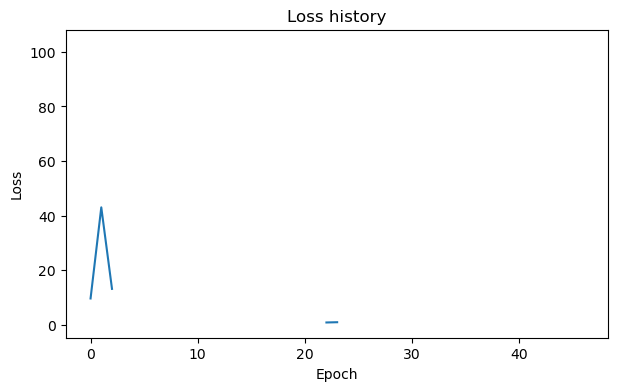

In [75]:
sm.plot_loss()

<h3 style="color:#0DB1A7  "> <u>Second trial</u> </h3>
Reducing the learning rate is useless, better change the optimization method.

In [76]:
""" 
Using sgd_with_momentum as weight_update with our data it is not the best choice...
"""
reg_strength = 1e-4
batch_size = 4
epochs = 50
learning_rate = 0.05 
weight_update = 'sgd_with_momentum'
#weight_update = 'sgd'
sm = Softmax(batch_size=batch_size, epochs=epochs, learning_rate=learning_rate, 
            reg_strength=reg_strength, weight_update=weight_update)
sm.train(X, y)
pred = sm.predict(X)
print(np.mean(np.equal(y, pred)))
print(pred)

Epoch: 0, Loss: 26.754640641854618
Epoch: 1, Loss: 82.4205638140324
Epoch: 2, Loss: 182.43037335401687
Epoch: 3, Loss: 173.55701892714288
Epoch: 4, Loss: 77.26462207760211
Epoch: 5, Loss: inf
Epoch: 6, Loss: inf
Epoch: 7, Loss: inf
Epoch: 8, Loss: 0.03767844557499268
Epoch: 9, Loss: inf
Epoch: 10, Loss: inf
Epoch: 11, Loss: inf
Epoch: 12, Loss: inf
Epoch: 13, Loss: inf
Epoch: 14, Loss: inf
Epoch: 15, Loss: inf
Epoch: 16, Loss: 155.6262811116326
Epoch: 17, Loss: 177.8249363245584
Epoch: 18, Loss: inf
Epoch: 19, Loss: inf
Epoch: 20, Loss: inf
Epoch: 21, Loss: inf
Epoch: 22, Loss: inf
Epoch: 23, Loss: inf
Epoch: 24, Loss: inf
Epoch: 25, Loss: inf
Epoch: 26, Loss: inf
Epoch: 27, Loss: 82.40832977580214
Epoch: 28, Loss: inf
Epoch: 29, Loss: inf
Epoch: 30, Loss: inf
Epoch: 31, Loss: inf
Epoch: 32, Loss: inf
Epoch: 33, Loss: inf
Epoch: 34, Loss: inf
Epoch: 35, Loss: 0.1952987107574265
Epoch: 36, Loss: inf
Epoch: 37, Loss: inf
Epoch: 38, Loss: inf
Epoch: 39, Loss: inf
Epoch: 40, Loss: inf
Epoc

/tmp/ipykernel_297697/2533682630.py:93: RuntimeWarning: divide by zero encountered in log
  loss = -np.log(softmax[np.arange(len(softmax)), y]).sum()


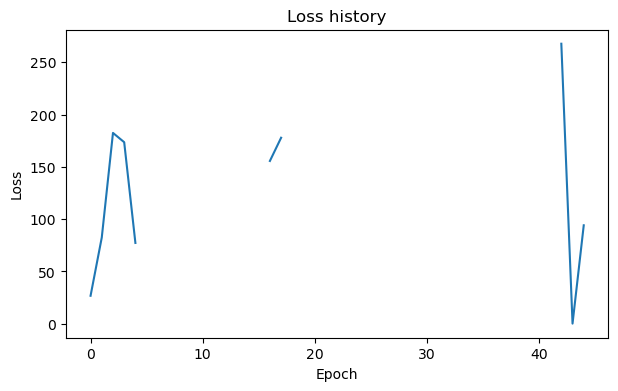

In [77]:
sm.plot_loss()

<h3 style="color:#0DB1A7  "> <u>Third trial</u> </h3>
Using sgd optimizer

In [78]:
reg_strength = 1e-4
batch_size = 4
epochs = 50
learning_rate = 0.05 
#weight_update = 'sgd_with_momentum'
weight_update = 'sgd'
sm = Softmax(batch_size=batch_size, epochs=epochs, learning_rate=learning_rate, 
            reg_strength=reg_strength, weight_update=weight_update)
sm.train(X, y)
pred = sm.predict(X)
print(np.mean(np.equal(y, pred)))
print(pred)

Epoch: 0, Loss: 41.498735369621414
Epoch: 1, Loss: inf
Epoch: 2, Loss: 21.160258881136723
Epoch: 3, Loss: 148.078892896976
Epoch: 4, Loss: 71.1577855994199
Epoch: 5, Loss: inf
Epoch: 6, Loss: inf
Epoch: 7, Loss: inf
Epoch: 8, Loss: 77.4024767801852
Epoch: 9, Loss: 124.87510952194914
Epoch: 10, Loss: 144.1395490611048
Epoch: 11, Loss: inf
Epoch: 12, Loss: inf
Epoch: 13, Loss: inf
Epoch: 14, Loss: inf
Epoch: 15, Loss: inf
Epoch: 16, Loss: 49.897536568901
Epoch: 17, Loss: 87.55564576986548
Epoch: 18, Loss: 140.07719112193905
Epoch: 19, Loss: 65.80751654972819
Epoch: 20, Loss: inf
Epoch: 21, Loss: inf
Epoch: 22, Loss: 15.215234781248846
Epoch: 23, Loss: 56.720818860807555
Epoch: 24, Loss: 88.26677551789803
Epoch: 25, Loss: 31.174932786500758
Epoch: 26, Loss: inf
Epoch: 27, Loss: inf
Epoch: 28, Loss: 44.728338769671396
Epoch: 29, Loss: 142.79032057020407
Epoch: 30, Loss: 4.463547841117703
Epoch: 31, Loss: 50.506295276666876
Epoch: 32, Loss: inf
Epoch: 33, Loss: 46.45194683192291
Epoch: 34, 

/tmp/ipykernel_297697/2533682630.py:93: RuntimeWarning: divide by zero encountered in log
  loss = -np.log(softmax[np.arange(len(softmax)), y]).sum()


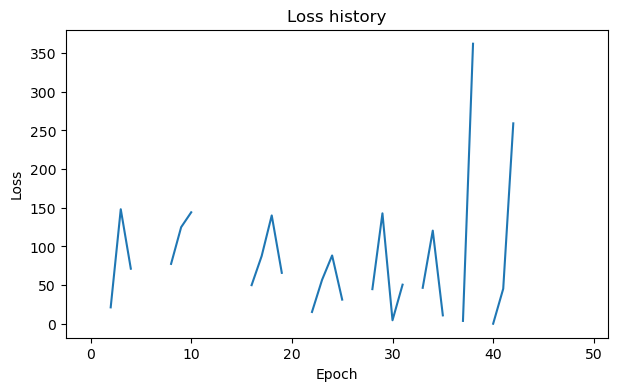

In [79]:
sm.plot_loss()

<h3 style="color:#0DB1A7  "> <u>Fourth trial</u> </h3> Using Adam optimizer

In [80]:
reg_strength = 1e-4
batch_size = 4
epochs = 50
learning_rate = 0.05 
weight_update = 'adam'
sm = Softmax(batch_size=batch_size, epochs=epochs, learning_rate=learning_rate, 
            reg_strength=reg_strength, weight_update=weight_update)
sm.train(X, y)
pred = sm.predict(X)
print(np.mean(np.equal(y, pred)))
print(pred)

Epoch: 0, Loss: 113.16727005746827
Epoch: 1, Loss: 92.87588224168879
Epoch: 2, Loss: 21.283950991408833
Epoch: 3, Loss: 14.509913210064866
Epoch: 4, Loss: 6.601856269884308
Epoch: 5, Loss: 5.709558405216974
Epoch: 6, Loss: 27.77354438950876
Epoch: 7, Loss: 0.02595378164810492
Epoch: 8, Loss: 2.893368240044591
Epoch: 9, Loss: 5.871379643933624
Epoch: 10, Loss: 5.582406856159235
Epoch: 11, Loss: 2.45194416467088
Epoch: 12, Loss: 1.0387920375503206
Epoch: 13, Loss: 0.7016730534837614
Epoch: 14, Loss: 14.412917178210808
Epoch: 15, Loss: 6.62834997336319
Epoch: 16, Loss: 5.194880070091219
Epoch: 17, Loss: 1.349667139191495
Epoch: 18, Loss: 1.4531826042776967
Epoch: 19, Loss: 22.26635398749234
Epoch: 20, Loss: 1.2888862567601627
Epoch: 21, Loss: 7.879124812378606
Epoch: 22, Loss: 2.4618608440104137
Epoch: 23, Loss: 1.4055219551122944
Epoch: 24, Loss: 0.4530440884669133
Epoch: 25, Loss: 5.605864073550878
Epoch: 26, Loss: 0.6734516316203938
Epoch: 27, Loss: 1.2290304548700504
Epoch: 28, Loss: 

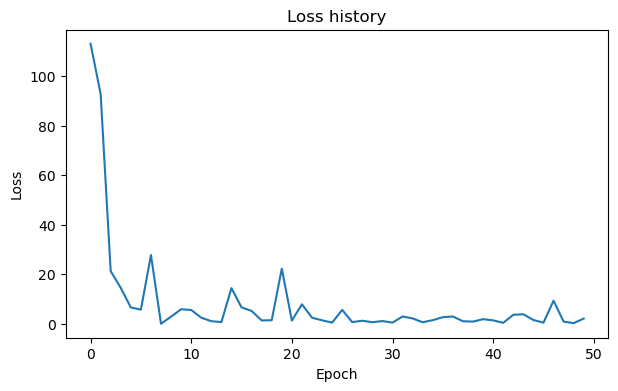

In [81]:
sm.plot_loss()